<h1> Predicting the Probability of a Loan being Crowdfunded on Kiva </h1>

This project attempts to find the probability of a loan being funded on the crowdfunding micro finance website – Kiva.org. 

Kiva Microfunds is a non-profit organization that allows people to lend money via the internet to low-income entrepreneurs and students throughout the world. Kiva's mission is "to connect people through lending to alleviate poverty." Since 2005, Kiva has crowd-funded more than a million loans, totaling more than $1 billion. The Kiva platform has attracted a community of well over a million lenders from around the world.


<h2> The Data </h2>

I downloaded a “snapshot” from Kiva’s own website with over 1 million records of borrowers and corresponding lenders https://build.kiva.org/docs/data/snapshots


<h2> Methodology </h2>

I treated this as a supervised learning classification problem. The binary variable 'funded’ indicates whether a loan was funded or not. 

<h3> Libraries </h3>

pandas for:
    data loading, wrangling, cleaning, and manipulation
    feature selection and engineering
    descriptive statistics

numpy for:
    array data structure, the primary input for classifiers
    model comparison
    matrix manipulation

scikit-learn for:
    classifier models
    parameter gridsearch
    model evaluation

matplotlib and seaborn for:
    data visualization



<h2> Data Wrangling and Cleaning </h2>

The data was loaded as a CSV and was relatively easy to manipulate with pandas. I had to do various string manipulations for “borrower_genders” and “pictured” as they were just loaded as a long string. Aside from that, there was standard one hot encoding for countries, activities and sectors as those were features that were key to my analysis. 


<h2> Feature Selection and Engineering </h2>

I have included as many variables as possible, both categorical and numeric. Kiva provided a lot of excellent data about demographic attributes, location and reasons why the borrower needs a loan. Details are in the code below. 

<h2> Model Fitting and Evaluation </h2>

Since this is a binary classification problem, I had 2 modelling approaches: 



<h4> Logistic Regression (Logit) </h4>

Logistic regression is useful in that it returns coefficients for each feature, which might be positive or negative, giving an indication of whether a particular feature is weakening or strengthening an application. 

<h4> Random Forest </h4>

This ensemble method pairs well with Decisions Trees, as it creates random trees and evaluates them. This is a good way to check many different trees, as opposed to DTC. 



<h1> Code </h1>

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams

In [2]:
# take a chunk of the file as its massive
chunksize = 200000
chunks = []
for chunk in pd.read_csv('loans.csv', chunksize=chunksize, low_memory=False):
    chunks.append(chunk)
df = pd.concat(chunks, axis=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1419607 entries, 0 to 1419606
Data columns (total 34 columns):
LOAN_ID                            1419607 non-null int64
LOAN_NAME                          1372049 non-null object
ORIGINAL_LANGUAGE                  1376356 non-null object
DESCRIPTION                        1376322 non-null object
DESCRIPTION_TRANSLATED             966929 non-null object
FUNDED_AMOUNT                      1419607 non-null float64
LOAN_AMOUNT                        1419607 non-null float64
STATUS                             1419607 non-null object
IMAGE_ID                           1376356 non-null float64
VIDEO_ID                           610 non-null float64
ACTIVITY_NAME                      1419607 non-null object
SECTOR_NAME                        1419607 non-null object
LOAN_USE                           1376334 non-null object
COUNTRY_CODE                       1419598 non-null object
COUNTRY_NAME                       1419607 non-null object
TOWN

In [4]:
'''Make everything lower case '''
df.columns = [x.lower() for x in df.columns]

<ul> <b> Key Observations : </b>
    <li> Description translated fields have many missing values. This is likely because they were already written in English and do not need translations <b> (32% missing) </b> </li>
  <li> Planned expiration time <b> (26% missing) </b>.  </li>
  <li> Currency exchange coverage rates <b> (23% missing) </b> </li>
  <li> Tags <b> (54% missing)</b> </li>
</ul>

<h3> Exploratory analysis </h3>

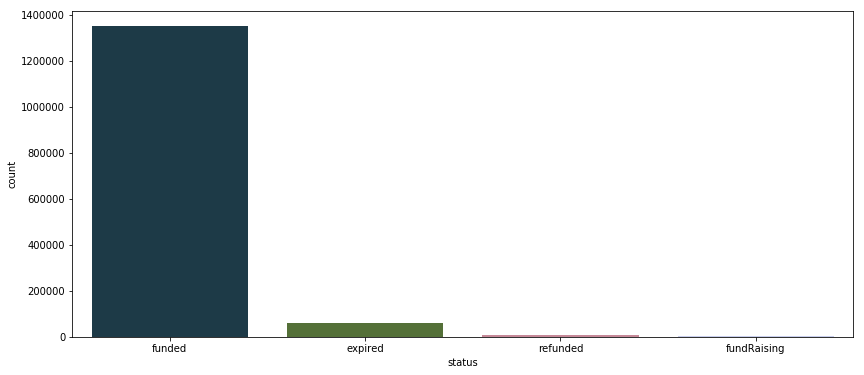

In [5]:
plt.figure(figsize=(14,6))
sns.countplot(x="status", data=df, palette="cubehelix")

<h3>Here lies our problem.. majority of the loans in this sample have been funded. This is going to skew our results considerably moving forward </h3> 

There are certain values here that will not be relevant to our analysis. These include image_id, video_id and town_name. Other variables, such as tags have too many missing values. I will also drop those for now.

In [6]:
df.drop(['image_id', 'video_id','tags','town_name','country_code','description','description_translated'], axis=1, inplace=True)

<h3> Exploring loan amounts </h3>

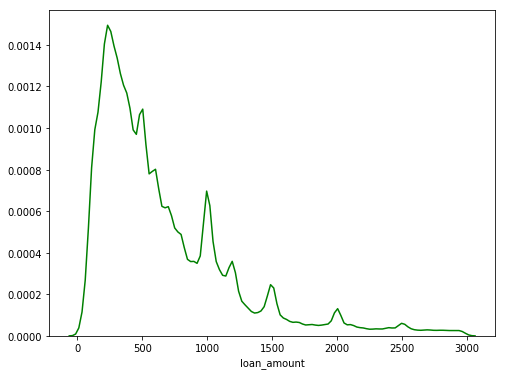

In [7]:
plt.figure(figsize=(8, 6))
sns.distplot(df['loan_amount'], color='g', bins=100,hist=False, kde_kws={'clip': (0.0, 3000)});

In [8]:
print ("The mean loan amount is", df.loan_amount.mean())
print ("The max loan amount is", df.loan_amount.max())
print ("The min loan amount is", df.loan_amount.min())

The mean loan amount is 832.2284265997562
The max loan amount is 100000.0
The min loan amount is 25.0


<h3> The average requested loan amount is about 800. The min of $25 makes sense as that is the minimum amount any lender can lend on Kiva </h3>

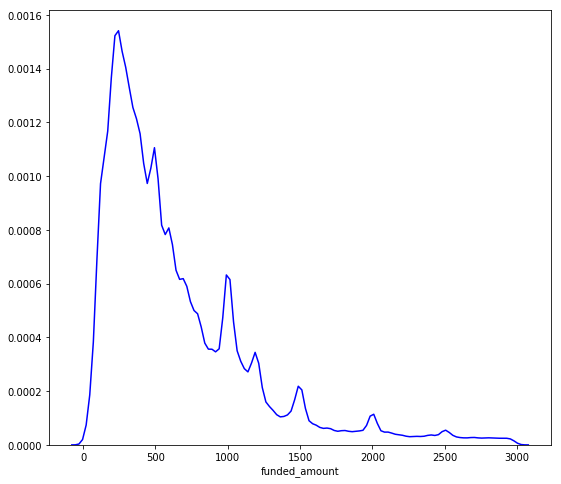

In [9]:
plt.figure(figsize=(9, 8))
sns.distplot(df['funded_amount'], color='b', bins=100,hist=False, kde_kws={'clip': (0.0, 3000)});

In [10]:
print ("The mean funded loan amount is", df.funded_amount.mean())
print ("The max funded loan amount is", df.funded_amount.max())
print ("The min funded loan amount is", df.funded_amount.min())

The mean funded loan amount is 796.125385405961
The max funded loan amount is 100000.0
The min funded loan amount is 0.0


<h3> The average funded loan amount is about 800. The min of 0 makes sense as there are a couple of loans that are not funded within this dataset </h3>

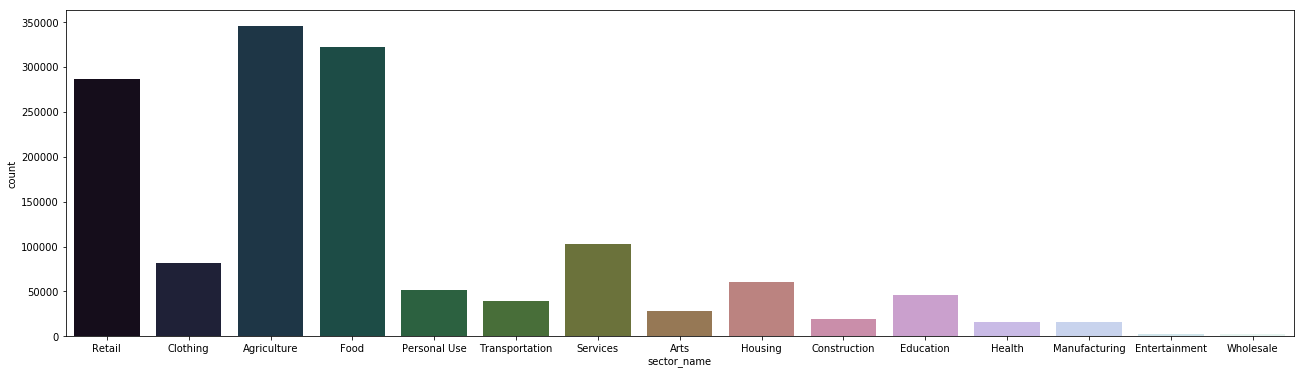

In [11]:
# exploring by sector
plt.figure(figsize=(22,6))
sns.countplot(x="sector_name", data=df, palette='cubehelix')

<h3> Most requested loans are in Agriculture and Food sectors. Intutively it makes sense as a lot of borrowers on Kiva are farmers </h3>

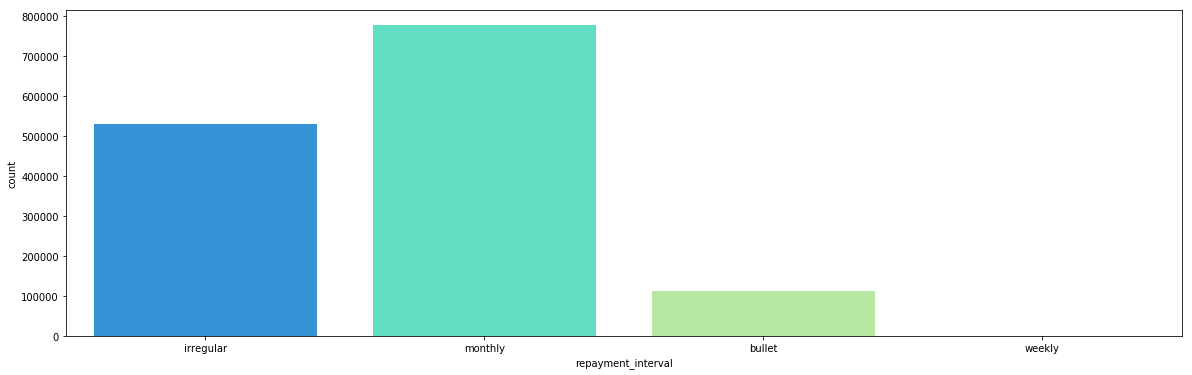

In [12]:
plt.figure(figsize=(20,6))
sns.countplot(x="repayment_interval", data=df, palette='rainbow')

<h3> Most loans are repaid on a monthly interval. Another majority are irregular and very few are bullet (paid towards the end of the term) </h3>

In [13]:
# converting funded vs non funded into binary variables for machine learning
def score_to_numeric(x):
    if x=='funded':
        return 1
    if x=='expired':
        return 0
    if x=='refunded':
        return 0
    if x=='fundRaising':
        return 0

In [14]:
df['status_num'] = df['status'].apply(score_to_numeric)

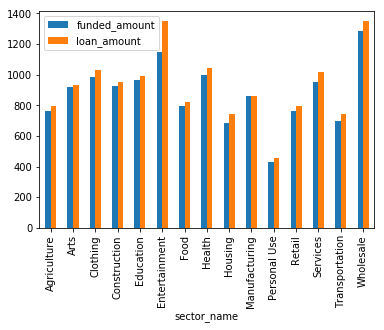

In [15]:
# Avg loan and funded amount by sector
df.pivot_table(index=['sector_name'], values=['loan_amount', 'funded_amount']).plot(kind= 'bar')

<h3> This tells me to expect a significant difference in funding rates across sectors </h3>

In [16]:
df.pivot_table(index=['country_name'], values=['status_num']).sort_values(by=['status_num'], ascending=False)

,status_num
country_name,
Papua New Guinea,1.000000
Saint Vincent and the Grenadines,1.000000
Lesotho,1.000000
Mauritania,1.000000
Namibia,1.000000
Canada,1.000000
Botswana,1.000000
Lao People's Democratic Republic,1.000000
Somalia,1.000000


In [17]:
df.pivot_table(index=['sector_name'], values=['status_num']).sort_values(by=['status_num'], ascending=False)

,status_num
sector_name,
Manufacturing,0.994081
Arts,0.989001
Education,0.977983
Wholesale,0.968246
Construction,0.968015
Food,0.962711
Personal Use,0.960746
Health,0.949701
Agriculture,0.948660


<h4> Expect country to be a significant predictor of whether a loan is funded or not </h4>

In [18]:
# Correlation matrix
df.corr()

,loan_id,funded_amount,loan_amount,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,status_num
loan_id,1.000000,-0.010612,0.012491,-0.674888,0.452031,0.076137,-0.079016,-0.224209,-0.132481,-0.105102
funded_amount,-0.010612,1.000000,0.960592,-0.008082,-0.066195,0.159129,0.875975,0.053751,0.045534,0.017201
loan_amount,0.012491,0.960592,1.000000,-0.020547,-0.057106,0.188700,0.836980,0.035009,0.034500,-0.131059
currency_exchange_coverage_rate,-0.674888,-0.008082,-0.020547,1.000000,-0.256584,-0.100725,0.040180,0.078716,0.024960,0.080260
partner_id,0.452031,-0.066195,-0.057106,-0.256584,1.000000,0.115435,-0.038321,-0.051707,-0.023171,-0.032987
lender_term,0.076137,0.159129,0.188700,-0.100725,0.115435,1.000000,0.211348,0.063248,0.145360,-0.145695
num_lenders_total,-0.079016,0.875975,0.836980,0.040180,-0.038321,0.211348,1.000000,0.079652,0.066337,0.037170
num_journal_entries,-0.224209,0.053751,0.035009,0.078716,-0.051707,0.063248,0.079652,1.000000,0.871624,0.099766
num_bulk_entries,-0.132481,0.045534,0.034500,0.024960,-0.023171,0.145360,0.066337,0.871624,1.000000,0.057532
status_num,-0.105102,0.017201,-0.131059,0.080260,-0.032987,-0.145695,0.037170,0.099766,0.057532,1.000000


<h4> Some of these correlations make a lot of sense! For example, higher loan amounts are correlated with a lower probability of funding. Number of lenders, journal entries and bulk entries increase probability of funding. Also, higher currenct exchange coverage rates increase probability of funding </h4>

<h2> Feature Creation </h2>

In [19]:
# for group loans, we want to assign a single female/male variable
df['female_count'] = df.borrower_genders.str.count('female') # counts number of females
df['total_gender_count'] = df.borrower_genders.str.count('male') # counts all genders
df['one_gender'] = np.where(df['female_count']>=(0.5*df['total_gender_count']), 
                                           'female', 'male') #assigned 'female' if female lenders make up 50% or more of the group

In [20]:
# single true/false variable of whether the borrower is pictured
df['pictured'] = np.where(df['borrower_pictured'].str.contains("true", case=False, na=False), 'true', 'false')

In [21]:
# getting rid of other columns that do not predictive purpose
lp = df.drop(['loan_id', 'loan_name','funded_amount','status','loan_use','currency_policy','borrower_pictured','posted_time','planned_expiration_time','disburse_time','raised_time','borrower_names','borrower_genders','borrower_pictured'], axis=1)

In [22]:
# ONE HOT ENCODE ALL THE THINGS
lp_dummies = pd.concat([lp.drop(['currency'], axis=1), pd.get_dummies(lp['currency'])], axis=1)

In [23]:
lp_dummies = pd.concat([lp_dummies.drop(['original_language'], axis=1), pd.get_dummies(lp_dummies['original_language'])], axis=1)

In [24]:
lp_dummies = pd.concat([lp_dummies.drop(['activity_name'], axis=1), pd.get_dummies(lp_dummies['activity_name'])], axis=1)

In [25]:
lp_dummies = pd.concat([lp_dummies.drop(['sector_name'], axis=1), pd.get_dummies(lp_dummies['sector_name'])], axis=1)

In [26]:
lp_dummies = pd.concat([lp_dummies.drop(['country_name'], axis=1), pd.get_dummies(lp_dummies['country_name'])], axis=1)

In [27]:
lp_dummies = pd.concat([lp_dummies.drop(['repayment_interval'], axis=1), pd.get_dummies(lp_dummies['repayment_interval'])], axis=1)

In [28]:
lp_dummies = pd.concat([lp_dummies.drop(['distribution_model'], axis=1), pd.get_dummies(lp_dummies['distribution_model'])], axis=1)

In [29]:
lp_dummies = pd.concat([lp_dummies.drop(['one_gender'], axis=1), pd.get_dummies(lp_dummies['one_gender'])], axis=1)

In [30]:
lp_dummies = pd.concat([lp_dummies.drop(['pictured'], axis=1), pd.get_dummies(lp_dummies['pictured'])], axis=1)

In [31]:
lp_dummies.head(2)

,loan_amount,currency_exchange_coverage_rate,partner_id,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,status_num,female_count,total_gender_count,...,bullet,irregular,monthly,weekly,direct,field_partner,female,male,false,true
0,125.0,0.1,126.0,7.0,3,2,1,1,1.0,1.0,...,0,1,0,0,0,1,1,0,0,1
1,400.0,0.1,201.0,8.0,11,2,1,1,1.0,1.0,...,0,0,1,0,0,1,1,0,0,1


In [32]:
# drop NA values
lp_dummies2 = lp_dummies.dropna()

In [33]:
# READY FOR SOME MACHINE LEARNING
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

In [34]:
# feature set
X = lp_dummies2.loc[:, lp_dummies2.columns != 'status_num']

In [35]:
# target variable
y = lp_dummies2.status_num

In [36]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(745707, 376) (745707,)
(319589, 376) (319589,)


<h2> Logistic regression </h2>

In [37]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
y_pred = LogReg.predict(X_test)

In [39]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[  5968,  10066],
       [  1420, 302135]])

In [40]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.37      0.51     16034
          1       0.97      1.00      0.98    303555

avg / total       0.96      0.96      0.96    319589



This model is good at determining if a loan will be funded, but not good at determining which loans will not fund. this is very likely to the class imbalance issue mentioned earlier.  

The model correctly identifies 40% of all expired loans as "not funded" 

<h3> any way to get feature importance? </h3> not really

<h3> Random Forest </h3>

In [41]:

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=123456, verbose=0,
            warm_start=False)

In [42]:
from sklearn.metrics import accuracy_score
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')

Out-of-bag score estimate: 0.973
Mean accuracy score: 0.974


In [43]:
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

          0       0.80      0.63      0.71     16034
          1       0.98      0.99      0.99    303555

avg / total       0.97      0.97      0.97    319589



The model correctly identifies 62% of all expired loans as "not funded"

In [44]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [45]:
feature_importances

,importance
num_lenders_total,3.360063e-01
loan_amount,2.250238e-01
lender_term,9.079882e-02
num_journal_entries,4.483235e-02
partner_id,3.458688e-02
female_count,1.776936e-02
total_gender_count,1.388052e-02
currency_exchange_coverage_rate,1.144534e-02
male,8.434157e-03
female,7.800972e-03


<h2> Conclusion </h2> 
What does this mean for the client? 
How will this change the business?
Optional: Monetary measurements to quantify and/or social impact analysis
(Largely be dictated by feature importance) 